# How to make use of GPU resources with PyTorch.


In [1]:
# This shell command will list any GPU's we have access to
!nvidia-smi

Thu Jun 16 13:37:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   1069MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Imports!
# Mostly torch and torchvision utilities, with plotting and tqdm helpers.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

We can check to see if we have a GPU like so:

In [3]:
torch.cuda.is_available()  # do we have a GPU? Should return True.

True

In [4]:
torch.cuda.device_count()  # how many GPUs do we have access to?

1

If you are seeing 0 GPU's available, go back and ensure you have started the notebook server with the correct settings. If you are having trouble restarting the server, try File -> Hub Control Panel, like so:

![image.png](docs/assets/hub_controlpanel.png)

## Now we know if we have a GPU device to use - let's use it!

In [5]:
# We'll assign the first GPU Device to our device variable.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # let's see what device we got

cuda:0


If our print output is not 'cuda:0' - our environment is not set up correctly. Ensure you have loaded a GPU enabled environment.

In [6]:
# let's see the name of our GPU!
torch.cuda.get_device_name(0)

'Tesla T4'

### How to load vectors / matrices / data onto the GPU.

In [7]:
X_train = torch.IntTensor([0, 30, 50, 75, 70])  # Initializing a Tensor of Ints
print(X_train.is_cuda, ",", X_train.device)  # Is tensor on GPU? Which device?

False , cpu


In [8]:
# Move it to the device we want.
X_train = X_train.cuda()
# or X_train = X_train.to(device)
# Now let's see!
print(X_train.is_cuda, ",", X_train.device)

True , cuda:0


In [9]:
# Alternatively, we can initialize the tensor directly on Device.
X_test = torch.cuda.IntTensor([30, 40, 50], device=device)
print(X_test.is_cuda, ",", X_test.device)

True , cuda:0


### How to load a Neural Network Model onto the GPU.

In [10]:
# Here is a basic fully connected neural network built in Torch.
# If we want to load it / train it on our GPU, we must first put it on the GPU
# Otherwise it will remain on CPU by default.

batch_size = 100


class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 784)
        self.fc2 = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

In [11]:
model = SimpleNet().to(device)  # Now, the network is loaded onto our GPU!

#### We've got our model loaded onto the GPU, let's now try training it on a simple dataset. We'll use the FashionMNIST dataset for this example - take a look [here](https://github.com/zalandoresearch/fashion-mnist).

In [12]:
"""
    Data loading, train and test set via the PyTorch dataloader.
"""
# Transform our data into tensors, normalizing our data.
train_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])

trainset = datasets.FashionMNIST('./data', train=True, download=True,
                   transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = datasets.FashionMNIST('./data', train=False,
                   transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

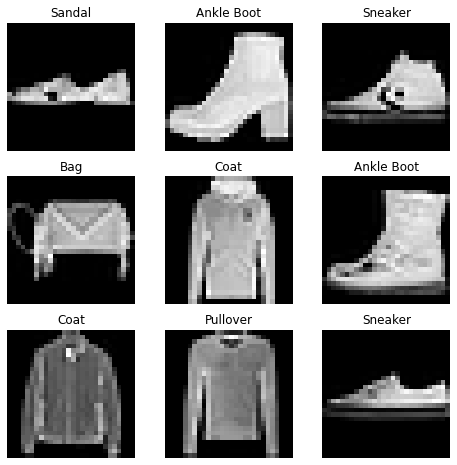

In [13]:
# Now that it's downloaded, let's take a look at what we have. 

# A dictionary to map our class numbers to their items.
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Plotting 9 random different items from our trainset.
figure = plt.figure(figsize=(8, 8))
for i in range(1, 3 * 3 + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(3, 3, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.view(28,28), cmap="gray")
plt.show()

Okay, our dataset *should* be all set, let's try training our model and see how well it classifies between the 10 classes of fashion related items!

In [14]:
def train(model, device, train_loader, optimizer, epoch):
    """Model training function"""
    model.train()
    print(device)
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [15]:
def test(model, device, test_loader):
    """Model evaluating function"""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    # we can use the no_grad method to improve computation speed in our test phase
    # as computing the gradient is not necessary in this step.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
# number of  training 'epochs'
EPOCHS = 5
# our optimization strategy used in training.
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

In [18]:
for epoch in range(1, EPOCHS + 1):
        print( f"EPOCH: {epoch}")
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

EPOCH: 1
cuda:0


600it [00:04, 123.74it/s]



Test set: Average loss: -0.5901, Accuracy: 6730/10000 (67%)

EPOCH: 2
cuda:0


600it [00:04, 123.44it/s]



Test set: Average loss: -0.6753, Accuracy: 7473/10000 (75%)

EPOCH: 3
cuda:0


600it [00:04, 120.47it/s]



Test set: Average loss: -0.7144, Accuracy: 7632/10000 (76%)

EPOCH: 4
cuda:0


600it [00:04, 124.02it/s]



Test set: Average loss: -0.7331, Accuracy: 7711/10000 (77%)

EPOCH: 5
cuda:0


600it [00:04, 121.00it/s]



Test set: Average loss: -0.7446, Accuracy: 7770/10000 (78%)



#### Now that we've finished training our very basic model, let's save it and give it a spin in the next notebook!

In [19]:
# Saving the model's weights!
torch.save(model.state_dict(), "mnist_fashion_SimpleNet.pt")